# Usage guide
Copyright: Donghu Guo

Author: Donghu Guo

Description: This is the notebook showing the general workflow of how to load and process the original data including: load vtu data, train and test split, standardise the data, create snapshot matrix, etc. See the table of contents for a clearer understanding of the structure of this notebook.

Github Repository: https://github.com/ese-msc-2021/irp-dg321

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sys
from sklearn.preprocessing import MinMaxScaler

In [2]:
sys.path.append("..")
import tools as t

os.environ["CUDA_VISIBLE_DEVICES"] = f"{0}"

2023-10-13 16:26:03.430224: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
root_path = '/home/dg321/gitTest/PRI/irp/data/' # set the root path where data is stored
save_path = 'output_vtus/case1_aae_pred/case1_aae_pred_' # 'testvtu/test_' 

cases_num = 1 # number of cases to recover
times = 720
nNodes = 54363   # 52572

vtu_start = 1
vtu_end   = 721  # 726
vtu_step  = 1
timesteps = 720
fields_unit_list = ['CO2_ppm', 'Velocity_X(m/s)', 'Velocity_Y(m/s)', 'Velocity_Z(m/s)', 'Temperature', 'Humidity', 'Virus load']

#### Load vtu data

In [ ]:
# read vtu points
filename = root_path + 'Cotrace_fixed/Cotrace_fixed_6.vtu'

mesh = meshio.read(filename)
points = mesh.points
print(points.shape)
print(points[0])

In [5]:
#--------------------------------#
#-- Choose variables           --#
#--------------------------------#
# The path where the vtu files are located
path = root_path + 'Cotrace_fixed_720/' 
# The prefix of the file name of the vtu file
name_simu = 'Cotrace_fixed'
vtu_start = 1
vtu_end   = 721  # 721
vtu_step  = 1
fields_list = ['Tracer', 'Velocity', 'Temperature', 'Humidity', 'Virus1']

In [6]:
times = 720
nNodes = 192060

In [ ]:
tracer = t.loadvtufile(path, name_simu, 'Tracer', vtu_start, vtu_end, vtu_step)
velocity = t.loadvtufile(path, name_simu, 'Velocity', vtu_start, vtu_end, vtu_step)
temp = t.loadvtufile(path, name_simu, 'Temperature', vtu_start, vtu_end, vtu_step)
humid = t.loadvtufile(path, name_simu, 'Humidity', vtu_start, vtu_end, vtu_step)
virus = t.loadvtufile(path, name_simu, 'Virus1', vtu_start, vtu_end, vtu_step)

vx = velocity[:,:,0].reshape(times,nNodes,1)
vy = velocity[:,:,1].reshape(times,nNodes,1)
vz = velocity[:,:,2].reshape(times,nNodes,1)

print(tracer.shape)
print(velocity.shape)
print(temp.shape)
print(humid.shape)
print(virus.shape)
print(vx.shape)

np.save(root_path + 'Cotrace_fixed_720_npys/tracer.npy', tracer)
np.save(root_path + 'Cotrace_fixed_720_npys/velocity.npy', velocity)
np.save(root_path + 'Cotrace_fixed_720_npys/temp.npy', temp)
np.save(root_path + 'Cotrace_fixed_720_npys/humid.npy', humid)
np.save(root_path + 'Cotrace_fixed_720_npys/virus.npy', virus)
np.save(root_path + 'Cotrace_fixed_720_npys/vx.npy', vx)
np.save(root_path + 'Cotrace_fixed_720_npys/vy.npy', vy)
np.save(root_path + 'Cotrace_fixed_720_npys/vz.npy', vz)


## Data exploration

In [5]:
for case in range(1,9):
    tracer = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_tracer.npy'.format(case,case))
    print(tracer.shape)

(720, 54363, 1)
(720, 54363, 1)
(720, 54363, 1)
(720, 54363, 1)
(720, 54363, 1)
(720, 54363, 1)
(720, 54363, 1)
(720, 54363, 1)


In [60]:

tracer = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_tracer.npy'.format(case,case))
velocity = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_velocity.npy'.format(case,case))
temp = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_temp.npy'.format(case,case))
humid = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_humid.npy'.format(case,case))
virus = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_virus.npy'.format(case,case))

vx = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_vx.npy'.format(case,case))
vy = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_vy.npy'.format(case,case))
vz = np.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_vz.npy'.format(case,case))

In [61]:
print(temp.shape)

(720, 54049, 1)


In [62]:
plt.plot(temp[:,30])

In [63]:
fields = [tracer, vx, vy, vz, temp, humid, virus]

In [64]:
fields_list = ['Tracer', 'Velocity_X', 'Velocity_Y', 'Velocity_Z', 'Temperature', 'Humidity', 'Virus1']

In [65]:
print(fields[0].shape)

(720, 54049, 1)


In [66]:
maxs = []
mins = []
for i in range(len(fields)):
    ma = np.amax(fields[i],axis=1)
    mi = np.amin(fields[i],axis=1)
    maxs.append(ma)
    mins.append(mi)


Text(0.5, 0.98, 'Min max values')

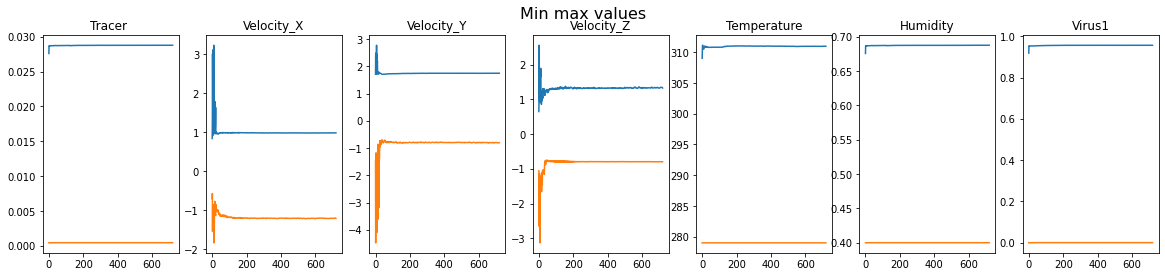

In [67]:
fig, ax = plt.subplots(1,7, figsize=[20,4])
for i in range(len(fields)):
    ax.flatten()[i].plot(maxs[i])
    ax.flatten()[i].plot(mins[i])
    ax.flatten()[i].set_title(fields_list[i])
fig.suptitle('Min max values', fontsize=16)

## Train test split

In [68]:
fields_train = []
fields_test = []
test_t_start = int(720*(100/120))
test_t_end = int(720*(120/120))

print(test_t_start)
print(test_t_end)

600
720


In [69]:
for i in range(len(fields)):
    field_train = fields[i][:test_t_start]
    field_test = fields[i][test_t_start:]
    
    fields_train.append(field_train)
    fields_test.append(field_test)

In [70]:
print(fields[0].shape)
print(fields_train[0].shape)
print(fields_test[0].shape)

(720, 54049, 1)
(600, 54049, 1)
(120, 54049, 1)


In [ ]:
# store train and test sets
joblib.dump(fields, root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_fields_all.pkl'.format(case, case))
joblib.dump(fields_train, root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_fields_train.pkl'.format(case, case))
joblib.dump(fields_test, root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_fields_test.pkl'.format(case, case))

## Standardise the Data 

In [26]:
fields = fields_train
fields_list = ['Tracer ', 'Velocity_X', 'Velocity_Y', 'Velocity_Z', 'Temperature', 'Humidity', 'Virus1']

In [27]:
print(len(fields))
print(fields[0].shape)

7
(600, 192060, 1)


Text(0.5, 0.98, 'histogram before scaling')

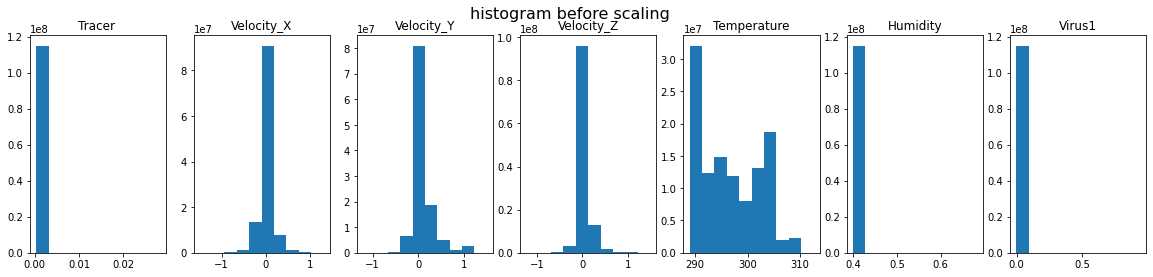

In [28]:
fig, ax = plt.subplots(1,7, figsize=[20,4])
for i in range(len(fields)):
    ax.flatten()[i].hist(fields[i].flatten())
    ax.flatten()[i].set_title(fields_list[i])
fig.suptitle('histogram before scaling', fontsize=16)

In [31]:
# change the output file name
fields_scaled = []
for i in range(len(fields)):
    scaler = MinMaxScaler((0, 1))
    scaler.fit(fields[i][:,:,0])
    field_scaled = scaler.transform(fields[i][:,:, 0])
    joblib.dump(scaler, root_path + 'Cotrace_fixed_720_npys/scalers/train_scaler01_{}.pkl'.format(fields_list[i]))
    print(fields[i].shape)
    print(field_scaled.shape)
    fields_scaled.append(field_scaled)
    

(600, 192060, 1)
(600, 192060)
(600, 192060, 1)
(600, 192060)
(600, 192060, 1)
(600, 192060)
(600, 192060, 1)
(600, 192060)
(600, 192060, 1)
(600, 192060)
(600, 192060, 1)
(600, 192060)
(600, 192060, 1)
(600, 192060)


Text(0.5, 0.98, 'histogram after scaling')

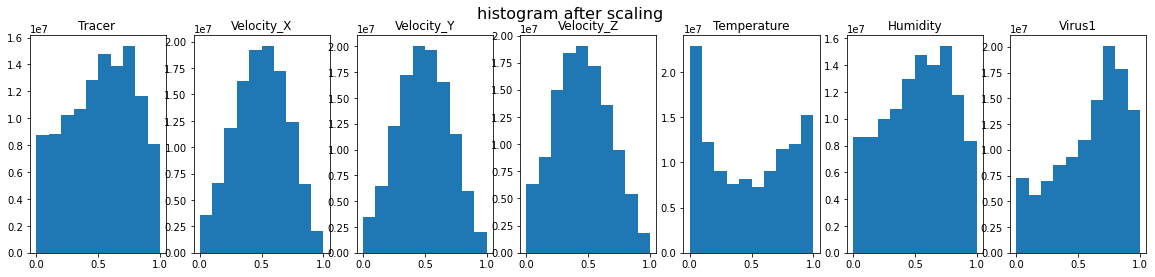

In [32]:
fig, ax = plt.subplots(1,7, figsize=[20,4])
for i in range(len(fields)):
    ax.flatten()[i].hist(fields_scaled[i].flatten())
    ax.flatten()[i].set_title(fields_list[i])
fig.suptitle('histogram after scaling', fontsize=16)

## Create Snapshot Matrix

In [33]:
all_values = np.hstack(fields_scaled)

In [34]:
print("Snapshot Matrix shape", all_values.shape)

Snapshot Matrix shape (600, 1344420)


In [ ]:
# Store the all data in the form of numpy.ndarray
joblib.dump(all_values, root_path + 'Cotrace_fixed_720_npys/train_snapshot_matrix.pkl')

## Load pod coefficients

In [13]:
case = 1
# Load matrix
all_values_test = joblib.load(
    root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_test_snapshot_matrix.pkl'.format(case, case))

# p_tot -> proportion of the variance we want to keep
# Can’t be set to 1, because 1 means that only 1 component will be left
p_tot = 0.9999999999999999 
# Create an instance of the PCA model
pca = PCA(p_tot)
test_pca = pca.fit_transform(all_values_test)
X_recovered_test = pca.inverse_transform(test_pca)
np.allclose(X_recovered_test, all_values_test)

pca_compress = pca

dif = sum(sum(all_values_test - X_recovered_test))
print(dif)

-5.670820422610976e-09


In [29]:
recon_error_test = dif/120/nNodes/7
print(recon_error_test)

-1.241832991848223e-16


In [14]:
error_test = all_values_test - X_recovered_test
error_sq_test = np.sqrt( np.multiply(error_test,error_test) )
dif_test =np.sqrt( sum(sum( error_sq_test )) )
print(dif_test)

0.0002848116498531723


In [15]:
recon_error_test = dif_test/120/nNodes/7
print(recon_error_test)

6.236990010125327e-12


In [4]:
case = 1
# Load matrix
all_values_train = joblib.load(
    root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_train_snapshot_matrix.pkl'.format(case, case))

# p_tot -> proportion of the variance we want to keep
# Can’t be set to 1, because 1 means that only 1 component will be left
p_tot = 0.9999999999999999 
# Create an instance of the PCA model
pca_train = PCA(p_tot)
train_pca = pca_train.fit_transform(all_values_train)
X_recovered_train = pca_train.inverse_transform(train_pca)
np.allclose(X_recovered_train, all_values_train)

pca_compress = pca_train

In [6]:
dif_train = sum(sum(all_values_train - X_recovered_train))
print(dif_train)

-3.8311870034093424e-10


In [8]:
recon_error_train = dif_train/600/nNodes/7
print(recon_error_train)

-1.677956297047862e-18


In [10]:
error_train = all_values_train - X_recovered_train
error_sq_train = np.sqrt( np.multiply(error_train,error_train) )
dif_train =np.sqrt( sum(sum( error_sq_train )) )

In [11]:
print(dif_train)

0.00034739217284243044


In [16]:
recon_error_train = dif_train/600/nNodes/7
print(recon_error_train)

1.5214837684701099e-12


In [12]:
case = 4

# PCA model
pca_compress = joblib.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_train_pca_compress_0.925.pkl'.format(case, case))
# POD coefficients
X_compressed = joblib.load(root_path + 'Cotrace_fixed_720_cases/case{}_npys/case{}_train_pod_coefficients_0.925.pkl'.format(case, case))

# scaler_minmax = MinMaxScaler((0,1))
# X_compressed = scaler_minmax.fit_transform(X_compressed)

In [8]:
print(X_compressed.shape)

(600, 66)


In [11]:
x_com  = pca_compress.fit_transform(all_values)
print(x_com.shape)

(600, 66)


In [12]:
# Find the cumulative sum of the explained variance ratio to plot
p = 0.932
cumsum_eig = np.cumsum(pca_compress.explained_variance_ratio_)
d_tot = pca_compress.n_components_
# Find the number of principle components 
d = np.argmax(cumsum_eig >= p) + 1
print("initial number of components = ", d_tot)
print("number of components after PCA = ", d)

plt.figure(figsize=(6,4))
plt.plot(cumsum_eig, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("principal components", xy=(d, p), xytext=(d, cumsum_eig[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.savefig('pca_norm_Explained_Variance.png')
plt.show()

initial number of components =  599
number of components after PCA =  84


initial number of components =  601
number of components after PCA =  100


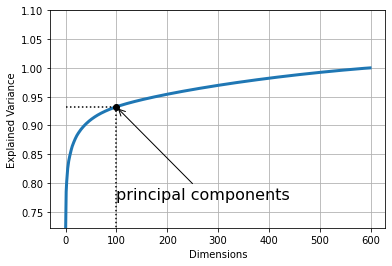

In [14]:
# Find the cumulative sum of the explained variance ratio to plot
p = 0.932
cumsum_eig = np.cumsum(pca_compress.explained_variance_ratio_)
d_tot = pca_compress.n_components_
# Find the number of principle components 
d = np.argmax(cumsum_eig >= p) + 1
print("initial number of components = ", d_tot)
print("number of components after PCA = ", d)

plt.figure(figsize=(6,4))
plt.plot(cumsum_eig, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("principal components", xy=(d, p), xytext=(d, cumsum_eig[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.savefig('pca_norm_Explained_Variance.png')
plt.show()

In [ ]:
plt.hist(X_compressed.flatten())
plt.title('histogram of train POD coefficients')
plt.show()

In [ ]:
num_sample = 2

fig, ax = plt.subplots(int(num_sample*0.5),2, figsize=[20,8])
for i in range(num_sample):

    ax.flatten()[i].plot(X_compressed[:,i], '-o')
fig.suptitle('The first {} pod coefficients'.format(num_sample), fontsize=16)

## Data exploration - test set

In [43]:
for i in range(len(fields_test)):
    print(fields_test[i].shape)

(120, 192060, 1)
(120, 192060, 1)
(120, 192060, 1)
(120, 192060, 1)
(120, 192060, 1)
(120, 192060, 1)
(120, 192060, 1)


In [44]:
fig, ax = plt.subplots(1,7, figsize=[20,4])
for i in range(len(fields_test)):
    ax.flatten()[i].hist(fields_test[i].flatten())
    ax.flatten()[i].set_title(fields_list[i])
fig.suptitle('histogram of Test set before scaling', fontsize=16)

Text(0.5, 0.98, 'histogram of Test set before scaling')

Text(0.5, 0.98, 'histogram of Test set after scaling')

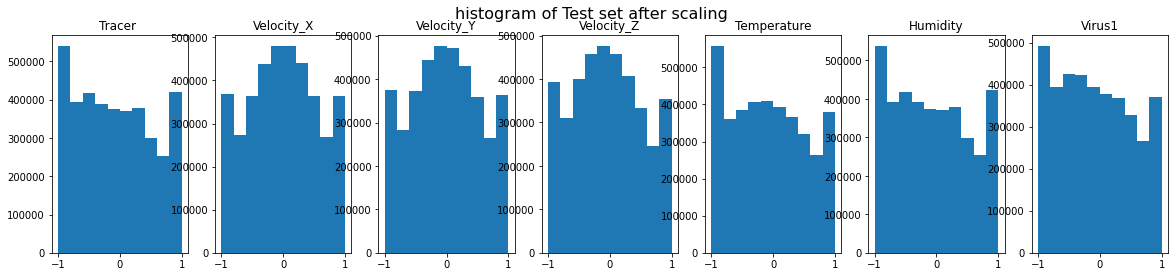

In [11]:
scalers = []
fields_scale = []

for i in range(len(fields_test)):
    scaler = joblib.load(root_path + 'Cotrace_fixed_720_npys/scalers/test_scaler01_' + fields_list[i] + '.pkl')
    field_scale_inverse = scaler.transform(fields_test[i][:,:,0])
    fields_scale.append(field_scale_inverse)

fig, ax = plt.subplots(1,7, figsize=[20,4])
for i in range(len(fields_test)):
    ax.flatten()[i].hist(fields_scale[i].flatten())
    ax.flatten()[i].set_title(fields_list[i])
fig.suptitle('histogram of Test set after scaling', fontsize=16)

Text(0.5, 0.98, 'histogram of Test set after scaling back')

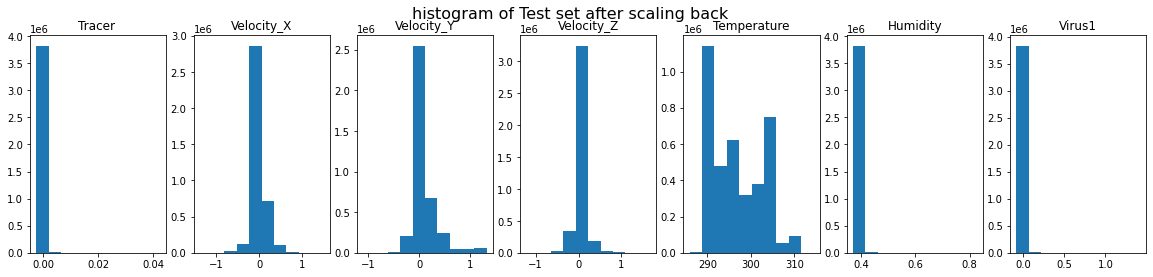

In [12]:
scalers = []
fields_scale_inverse = []

for i in range(len(fields_scale)):
    scaler = joblib.load(root_path + 'toydata/scalers/test_scaler_' + fields_list[i] + '.pkl')
    field_scale_inverse = scaler.inverse_transform(fields_scale[i])
    fields_scale_inverse.append(field_scale_inverse)

fig, ax = plt.subplots(1,7, figsize=[20,4])
for i in range(len(fields_scale)):
    ax.flatten()[i].hist(fields_scale_inverse[i].flatten())
    ax.flatten()[i].set_title(fields_list[i])
fig.suptitle('histogram of Test set after scaling back', fontsize=16)

In [16]:
print(fields_scale_inverse[4][10, :][:10])
print(fields_scale_inverse[4][11, :][:10])
print(fields_scale_inverse[4][19, :][:10])

[288.99999993 293.82400304 289.01426081 289.00632056 289.00976027
 291.46678284 294.80754714 291.93956075 292.31564539 289.14947417]
[288.99999995 293.49081292 289.01417866 289.00581296 289.00914518
 291.34640729 294.60657145 291.7389639  292.21861372 289.10403865]
[289.         293.67358693 289.01183065 289.00515968 289.01505066
 291.33062486 295.33150595 291.7524408  292.06694856 289.14505956]


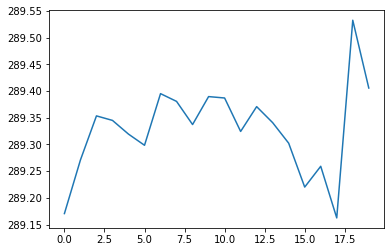

In [19]:
plt.plot(fields_scale_inverse[4][:, 124])